# Formula 1 Dataset Analysis (2001~2024)

## Why data from 2001?
Formula 1 cars undergo regulation changes regularly. While regulation change is motivated for the drivers' safety, cost control, and closer competition, it affects the car performance massively - resetting constructor dominance every year.
In 2001, the massive regulation change was introduced - front & rear wing changes, crash standards tightening, driver aids, such as traction control, being reintroduced.   \
Because Formula 1 cars are different year by year, older data from 20th century may be irrelevant. Also, the oldest driver on the current grid, Fernando Alonso, joined Formula 1 in 2001, which makes 2001 a meaningful data. 

## Analysis Outline
1.  **Introduction & Setup**: Justifying the 2001-2024 timeframe.
2.  **Data Loading & Cleaning**: Preparing the datasets for analysis.
3.  **Exploratory Data Analysis (EDA)**
    *   Constructor Dominance Over Time
    *   Qualifying vs. Race Position Correlation
    *   Average Driver Position Gain/Loss (Handling Outliers)
    *   Analysis of DNF (Did Not Finish) Causes
4.  **Statistical Analysis**
    *   T-Test: Comparing Constructor Performance in Different Eras
    *   Confidence Interval: Pole Sitter's Final Position


### Data
- **results**: race results, with starting positions and final result.
- **races**: information of each race
- **drivers**: information of each driver
- **qualifying**: information of qualifying session 
- **pit_stops**: data of pit stops during races
- **sprint_results**: sprint race results (introduced in 2021)
- **constructor_results**: race results of the constructor's championship
- **constructors**: information of constructors
- **status**: explanation for each statusId

### Loading packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.read_csv('./data/results.csv', na_values='\\N')
races = pd.read_csv('./data/races.csv', na_values='\\N')
drivers = pd.read_csv('./data/drivers.csv', na_values='\\N')
qualifying = pd.read_csv('./data/qualifying.csv', na_values='\\N')
pit_stops = pd.read_csv('./data/pit_stops.csv', na_values='\\N')
sprint_results = pd.read_csv('./data/sprint_results.csv', na_values='\\N')
constructor_results = pd.read_csv('./data/constructor_results.csv', na_values='\\N')

constructors = pd.read_csv('./data/constructors.csv')

### Clean data

#### Filtering years (2001~2024)   
Note: `raceId` does not represent the order of the race!

In [2]:
# filter year 2001~2024 (start by races.csv because it has year information)
races = races.loc[races['year'].isin(range(2001, 2025))].sort_values(by=['year', 'round']).reset_index(drop=True).sort_values(by=['year', 'round'])
# races.head(5)

valid_raceId = races['raceId'].unique()

# filter year for other datasets
results = results.loc[results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# results.head(5)

drivers = drivers.loc[drivers['driverId'].isin(results['driverId'])].sort_values(by='driverId').reset_index(drop=True)
# drivers.head(5)

qualifying = qualifying.loc[qualifying['raceId'].isin(valid_raceId)].sort_values(by=['qualifyId', 'position']).reset_index(drop=True)
qualifying.head(5)

pit_stops['time'] = pd.to_datetime(pit_stops['time'], format='%H:%M:%S').dt.time
# pit_stops.dtypes
pit_stops = pit_stops.loc[pit_stops['raceId'].isin(valid_raceId)].sort_values(by=['time']).reset_index(drop=True)
# pit_stops.head(5)

sprint_results['position'] = sprint_results['position'].astype('Int64') # int64 is used to handle \N (NA) values
sprint_results = sprint_results.loc[sprint_results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# sprint_results.dtypes => reveals that 'position' column is not in integer type, hindering the accurate sort order.
# sprint_results.dtypes
# sprint_results.head(10)

constructor_results = constructor_results.loc[constructor_results['raceId'].isin(valid_raceId)].sort_values(by=['constructorResultsId', 'constructorId']).reset_index(drop=True).dropna(axis=1)

#### Checking duplicates (Deduplication)

In [3]:
print(races.duplicated().sum())
print(results.duplicated().sum())
print(drivers.duplicated().sum())
print(qualifying.duplicated().sum())
print(pit_stops.duplicated().sum())
print(sprint_results.duplicated().sum())
print(constructor_results.duplicated().sum())
print(constructors.duplicated().sum())

0
0
0
0
0
0
0
0


Great, it seems there are no duplicates in these data!


## EDA

### Constructors 

#### Constructors Dominance
- Goal: Explore how constructor dominance has shifted over the years by visualizing their championship points.

In [4]:
races_const_merged = pd.merge(races, constructor_results, on='raceId', how='outer', suffixes=('','_races')).sort_values(by=['year', 'round']).reset_index(drop=True)
races_const_merged = races_const_merged.dropna(axis=1)

constructor_points_sum = races_const_merged.groupby(['year', 'constructorId'])['points'].sum().reset_index().sort_values(by=['year', 'constructorId'])

# Since there are too many constructors, I need to select a few. 
# I choose Ferrari, Renault, Brawn, Redbull, and Mercedes

# Retrieve constructorIds for these teams
selected_const = ['ferrari', 'renault', 'red_bull', 'mercedes', 'brawn', 'mclaren']
selected_const_id = constructors.loc[constructors['constructorRef'].isin(selected_const), ['constructorRef', 'constructorId']].reset_index(drop=True)
selected_const_id

,constructorRef,constructorId
0,mclaren,1
1,renault,4
2,ferrari,6
3,red_bull,9
4,brawn,23
5,mercedes,131


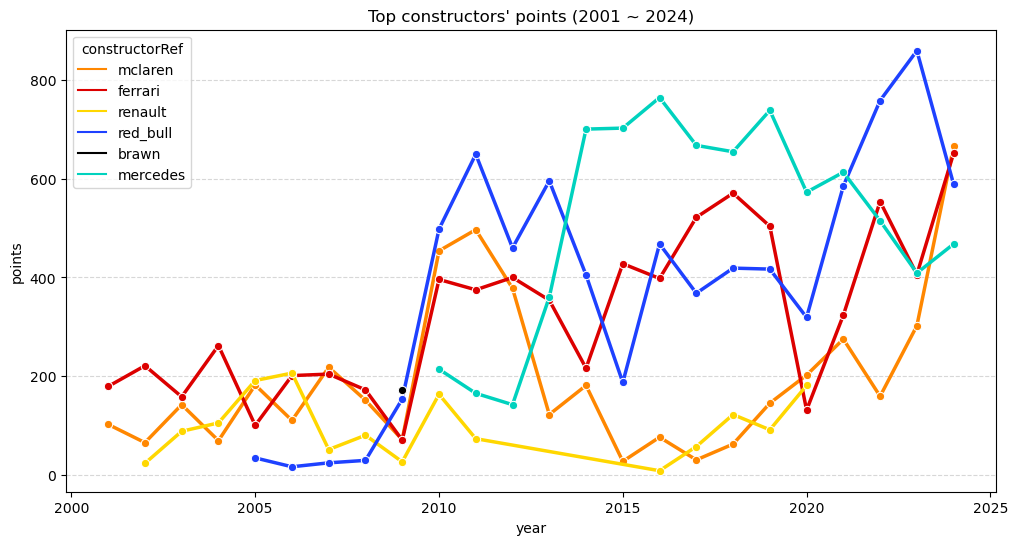

In [5]:
# keep constructors in selected_const_id
constructor_points_sum = constructor_points_sum.loc[constructor_points_sum['constructorId'].isin(selected_const_id['constructorId'])]
# merge selected_const_id and constructor_points_sum on 'constructorId'
constructor_points_sum = constructor_points_sum.merge(selected_const_id, how='left', on='constructorId').sort_values(by=['year', 'constructorId'])

# visualize

custom_color = {
    'mercedes': '#00D2BE',
    'ferrari': '#DC0000',
    'red_bull': '#1E41FF',
    'mclaren': '#FF8700',
    'renault': '#FFD700',
    'brawn': '#000000'
}
plt.figure(figsize=(12, 6))
sns.lineplot(data=constructor_points_sum, x='year', y='points', hue='constructorRef', marker='o', linewidth=2.5, palette=custom_color)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title("Top constructors' points (2001 ~ 2024)")
plt.show()

- From 2001 to 2009, you can clearly see that Ferrari was dominant, except for 2005 and 2006, when Fernano Alonso (the GOAT) took two championships.  
- Brawn GP (Honda GP until 2008 and Mercedes AMG since 2010) only appeared in 2009.
- From 2010 to 2013, Red Bull Racing was dominant with Sebastian Vettel.
- However, from 2014 to 2021, Mercedes AMG Petronas was very dominant.
- Again, from 2022 to 2023, red bull racing won the constructors championship.
- At the end of the graph, you can see Red Bull Racing's rapid drop in performance, which is still undergoing. 
- Mclaren's recent performance is impressive. Before 2021, Mclaren used Honda Engine and underperformed. They were able to turn the table after agreement with Mercedes on the usage of their engine. Mclaren's performance is still mind-blowing to this day (2025).

### Drivers

#### Qualifying positions and race result correlation  
- Goal: How much are qualifying position and race result related? Explore by getting correlation value and visualizing it.

In [6]:
# drop columns that are irrelevant for this analysis: col q1 to q3
qualifying_mod = qualifying.drop(['q1', 'q2', 'q3'], axis=1)
# merge results df and qualifying_mod df
qual_res_merged = qualifying_mod.merge(
    results,
    how='left',
    on=['raceId', 'driverId', 'constructorId'],
    suffixes=('_qualifying', '_race')
)

correlation = qual_res_merged['position_qualifying'].corr(qual_res_merged['position_race'])
print(f'Correlation between qualifying position and race result: {correlation:.3f}')

Correlation between qualifying position and race result: 0.761


We got **0.761**.   
0 means there is no linear relationship, while 1 means strong positive relationship (good qualifying -> good result)

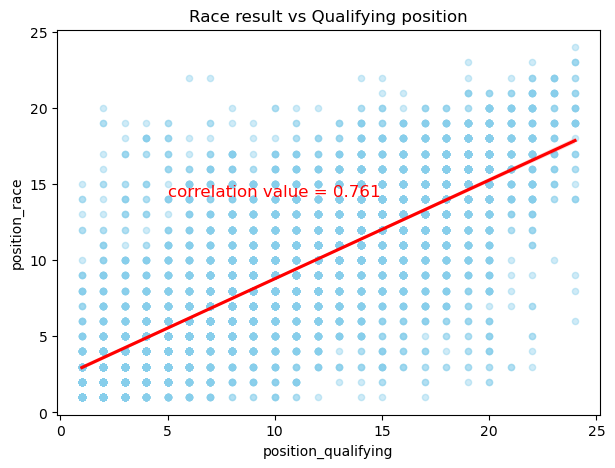

In [7]:
# We are analyzing relationship between the two variables. Regression plot will do for visualization.
plt.figure(figsize=(7, 5))
sns.regplot(
    data=qual_res_merged,
    x='position_qualifying',
    y='position_race',
    scatter_kws={'alpha': 0.4, 's':20, 'color':'skyblue'},
    line_kws={'color':'red'}
)
plt.text(5, 15,
         f"correlation value = {correlation:.3f}",
         fontsize=12,
         va='top',
         color='red')
plt.title('Race result vs Qualifying position')
plt.show()

This is a visualized version.    


To conclude, 
1. We can see positive relationship between starting position and result.  
2. For deeper insights, considering race results with DNF (`NaN`) will be crucial. 

#### Average position gain/loss  
- Goal: Explore how many positions drivers gain during races on average. 

In [8]:
qual_res_merged['position_gain'] = qual_res_merged['position_qualifying'] - qual_res_merged['position_race']
driver_avg_gain = qual_res_merged.groupby('driverId')['position_gain'].mean().sort_values(ascending=False).reset_index().rename(columns={'position_gain': 'avg_position_gain'}).dropna(axis=0)
driver_avg_gain = driver_avg_gain.merge(drivers[['driverId', 'driverRef']], how='left', on='driverId')

print(driver_avg_gain)
print(driver_avg_gain['avg_position_gain'].describe())

     driverId  avg_position_gain driverRef
0          66          12.000000    mcnish
1          34           9.000000       ide
2          56           7.000000    irvine
3          61           7.000000      enge
4          53           6.600000     kiesa
..        ...                ...       ...
113         3           0.197740   rosberg
114       857           0.162791   piastri
115       846           0.000000    norris
116       822          -0.154545    bottas
117        48          -0.333333      gene

[118 rows x 3 columns]
count    118.000000
mean       2.572065
std        1.920040
min       -0.333333
25%        1.255147
50%        2.116883
75%        3.510244
max       12.000000
Name: avg_position_gain, dtype: float64


Now here's the problem. I am trying to see the average gain/loss of the drivers.    
However, I noticed there are some extraordinary average position gains, such as 12 position gains.   
**Some drivers have raced in Formula One once or only few times, as a reserve driver or test driver. This kind of drivers may have unrealistic average position gain.**  
This may make the result inaccurate.   

There are two ways to take care of this problem.
1. **Use sampling**: We can use samples, calculate average position gains, and get the sampling distribution to see if it represents the whole.
   - By Central Limit Theorem, the sameple mean gets closer to the population mean, as sample size increases
2. **Z-score**: According to *empirical rule*, about 99.7% of data in a normal distribution is within ±3 standard deviations from the mean. Therefore, observations beyond ±3 are considered outliers.


Here, I will implement **Z-score** to rule out the outliers (entries outside of ±3 standard deviation) because the population of the data is not large enough.

The **Z-score** is calculated as:  

$$
z = \frac{X - \mu}{\sigma}
$$

Where:
- $X$ = the value
- $\mu$ = the mean of the dataset
- $\sigma$ = the standard deviation of the dataset   


`scipy.stats` packages is used to conveniently calculate z-score.

<Axes: >

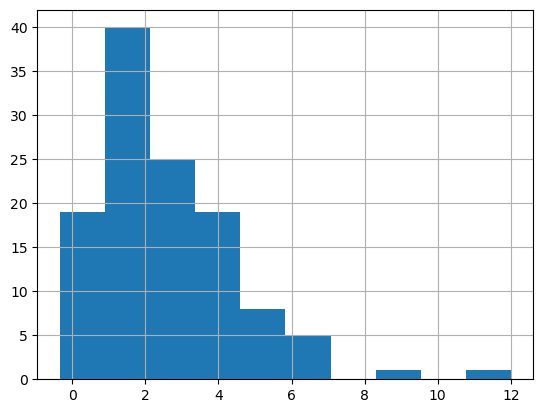

In [9]:
# First, lets visualize how the values are distributed.
driver_avg_gain['avg_position_gain'].hist()

In [10]:
# There are clearly outliers. 
# import scipy.stats package to calculate z-score.

import scipy.stats as stats
driver_avg_gain['z_score'] = stats.zscore(driver_avg_gain['avg_position_gain'])

driver_avg_gain = driver_avg_gain.loc[driver_avg_gain['z_score'].abs() <= 3]
driver_avg_gain

,driverId,avg_position_gain,driverRef,z_score
2,56,7.000000,irvine,2.316003
3,61,7.000000,enge,2.316003
4,53,6.600000,kiesa,2.106786
5,59,6.000000,bernoldi,1.792960
6,812,5.888889,chandhok,1.734844
...,...,...,...,...
113,3,0.197740,rosberg,-1.241875
114,857,0.162791,piastri,-1.260155
115,846,0.000000,norris,-1.345302
116,822,-0.154545,bottas,-1.426136


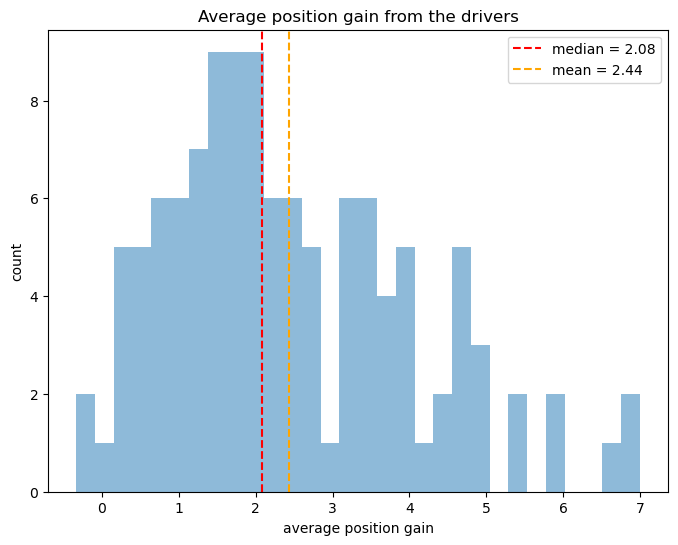

In [11]:
# histogram used to show distribution.
median = driver_avg_gain['avg_position_gain'].median()
mean = driver_avg_gain['avg_position_gain'].mean()

plt.figure(figsize=(8, 6))
sns.histplot(data=driver_avg_gain, x='avg_position_gain', bins=30, alpha=0.5, edgecolor='none')
plt.axvline(x=median, color='red', linestyle='--', label=f'median = {median:.2f}')
plt.axvline(x=mean, color='orange', linestyle='--', label=f'mean = {mean:.2f}')
plt.title('Average position gain from the drivers')
plt.xlabel('average position gain')
plt.ylabel('count')
plt.legend()
plt.show()

The median value for `avg_position_gain` is 2.08, and mean value is 2.44.    
We can see that many drivers have average position gain of around 1~3, which makes sense.    
Gaining positions in Formula One is extremely challenging and depends on countless factors, such as team strategy and weather fluctuations.

### Top causes for **DNF** (did not finish)

In terms of DNF, we can take a look in two ways
1. **Yearly DNF**: This will reveal the reliability and number of accidents of f1 cars by year.
2. **DNF by circuits**: This will reveal the difficulty / features of each circuit.  

#### 1. DNF by year  
- Goal: Identify top DNF causes by year. 

In [12]:
# For this analysis, we need to import status.csv, which contains status name for each statusId.
status = pd.read_csv('./data/status.csv')
print(status.head())
print('-'*50)
print(status.info())

   statusId        status
0         1      Finished
1         2  Disqualified
2         3      Accident
3         4     Collision
4         5        Engine
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   statusId  139 non-null    int64 
 1   status    139 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.3+ KB
None


There are 139 different status ids.

In [13]:
# add race year and round column to results dataframe by merging.
results_new = results.merge(races[['raceId', 'year', 'round']], on='raceId').sort_values(by=['year', 'round']).reset_index(drop=True)
# print(results_new.head(5))
# print('-'*50)
print(results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9706 entries, 0 to 9705
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         9706 non-null   int64  
 1   raceId           9706 non-null   int64  
 2   driverId         9706 non-null   int64  
 3   constructorId    9706 non-null   int64  
 4   number           9706 non-null   float64
 5   grid             9706 non-null   int64  
 6   position         7708 non-null   float64
 7   positionText     9706 non-null   object 
 8   positionOrder    9706 non-null   int64  
 9   points           9706 non-null   float64
 10  laps             9706 non-null   int64  
 11  time             4597 non-null   object 
 12  milliseconds     4597 non-null   float64
 13  fastestLap       8252 non-null   float64
 14  rank             8510 non-null   float64
 15  fastestLapTime   8252 non-null   object 
 16  fastestLapSpeed  8252 non-null   float64
 17  statusId      

In [14]:
# filter null positions.
results_null_pos = results_new.loc[results_new['position'].isna()]

# group by year and count for each status id.
status_count = results_null_pos.groupby('year')['statusId'].value_counts().reset_index(name='count').sort_values(by=['year', 'statusId'])

# statusId = 1 indicates the driver finished the race. 
# We do not need this information, so let's filter out statusId = 1
status_count = status_count.loc[status_count['statusId'] != 1]
status_count

,year,statusId,count
16,2001,2,1
13,2001,3,2
1,2001,4,23
0,2001,5,30
3,2001,6,13
...,...,...,...
538,2024,31,6
549,2024,34,1
544,2024,54,2
545,2024,130,2


We now have `status_count` dataframe, which has the number of each statusId for each year.     
Since all 139 status ids are not able to be plotted, let's extract top 5 status.

In [15]:
# group by year. Then apply the lambda function to each group(year), which takes top 5 values based on count column
status_count_top = status_count.groupby('year', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))

# let's add status name to the dataframe.
status_count_top = status_count_top.merge(status, on='statusId').sort_values(by=['year', 'count'], ascending=[True, False]).reset_index(drop=True)
status_count_top 

,year,statusId,count,status
0,2001,5,30,Engine
1,2001,4,23,Collision
2,2001,20,20,Spun off
3,2001,6,13,Gearbox
4,2001,9,8,Hydraulics
...,...,...,...,...
115,2024,4,12,Collision
116,2024,3,7,Accident
117,2024,31,6,Retired
118,2024,5,4,Engine


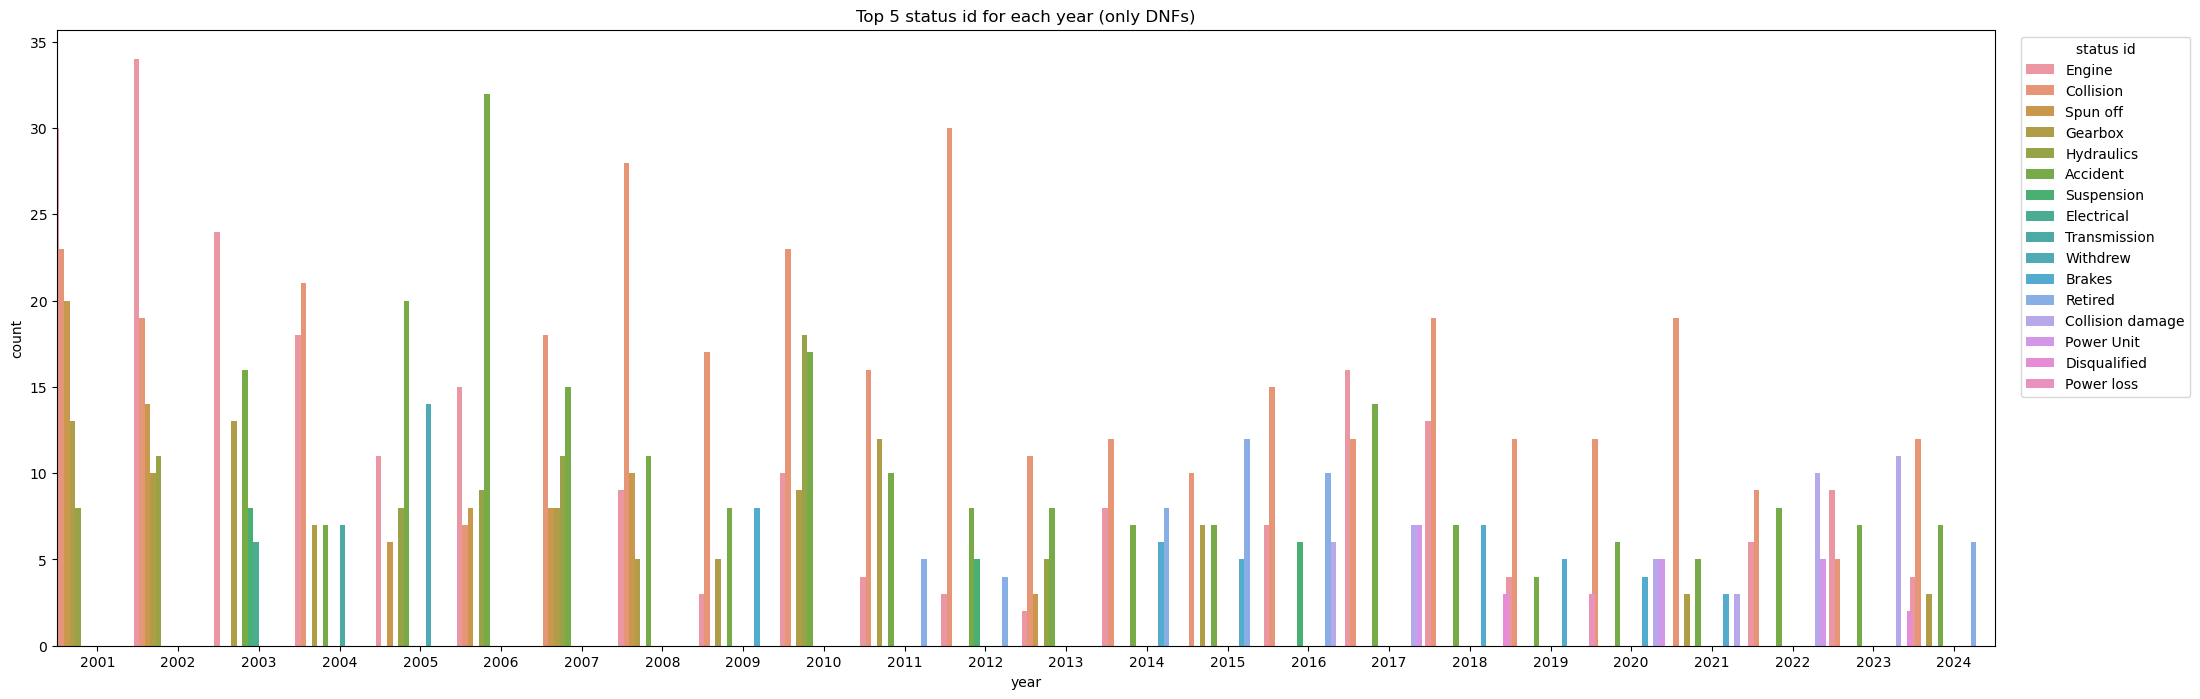

In [16]:
plt.figure(figsize=(25, 8))

sns.barplot(data=status_count_top, x='year', y='count', hue='status', width=1.1)
plt.xlabel('year')
plt.ylabel('count')
plt.title('Top 5 status id for each year (only DNFs)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title='status id')
plt.show()

Key findings
- In recent years, **Collision** is the main factor of DNF, with **Engine** failure also being the big cause of DNFs.
- 2006 was when 2.4L V8 engines replaced 3.0L V10. Significant increase in **Electrical** failure is recorded.
- In 2014, 1.6 V6 turbo hybrid units replaced beautiful-sounding V8s. However, no remarkable change is seen in 2014. This contradicts well-known information that the new V6 engine brought reliability issues due to its complex system. (MGU-K, MGU-H, energy storage systems, etc)

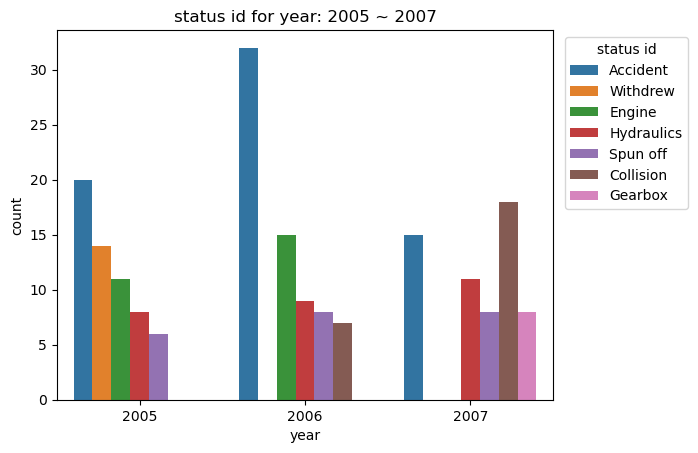

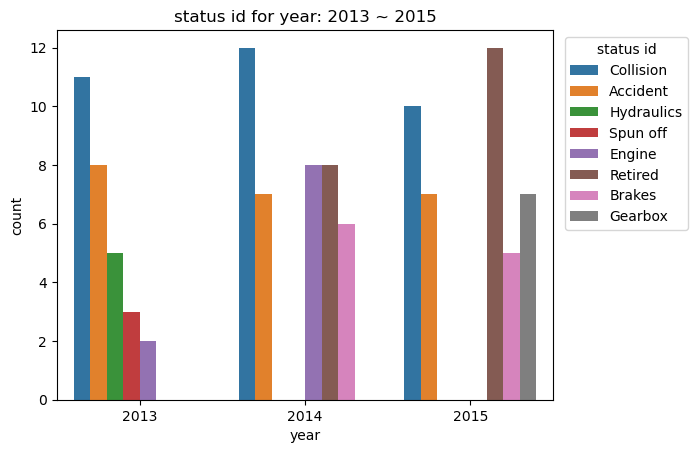

In [17]:
# visualization by key years where significant regulation changes were made.
# 1. 2006: v8 introduction
status_count_1 = status_count_top.loc[(status_count_top['year'] >= 2005) & (status_count_top['year'] < 2008)]

# 2. 2014: v6 hybrid turbo introduction
status_count_2 = status_count_top.loc[(status_count_top['year'] >= 2013) & (status_count_top['year'] < 2016)]

# viz
sns.barplot(data=status_count_1, x='year', y='count', hue='status')
plt.xlabel('year')
plt.ylabel('count')
plt.title('status id for year: 2005 ~ 2007')

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title='status id')
plt.show()

sns.barplot(data=status_count_2, x='year', y='count', hue='status')
plt.xlabel('year')
plt.ylabel('count')
plt.title('status id for year: 2013 ~ 2015')

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title='status id')
plt.show()


Key findings
- The first graph shows the year 2005 ~ 2007. In 2006, the engine shifted from V10s to V8s. We can clearly see the increase of **Engine** and **Hydraulic** failures.
- The second graph shows the year 2013 ~ 2015. The current 1.6L V6 hybrid turbo engines were introduced in 2014. 2014 shows remarkable increase of **Engine** problems. 

Possible improvements
- The data `status` has so many different status ids. Grouping them into smaller groups, such as Engine, Electrical, Collision, will make a more meaningful result. However, for now, this is beyond my capability.

#### 2. DNF by circuits  
- Goal: Each circuit presents unique challenges - from high speed straights to unpredictable weather- that may lead to different DNF patterns. This analysis will explore those track-specific trends.

Let's see DNF causes for each circuit.  
I will extract 7 circuits with the most DNFs and top 5 DNF causes.  

The logic is the same as the previous _DNF by year_ analysis.

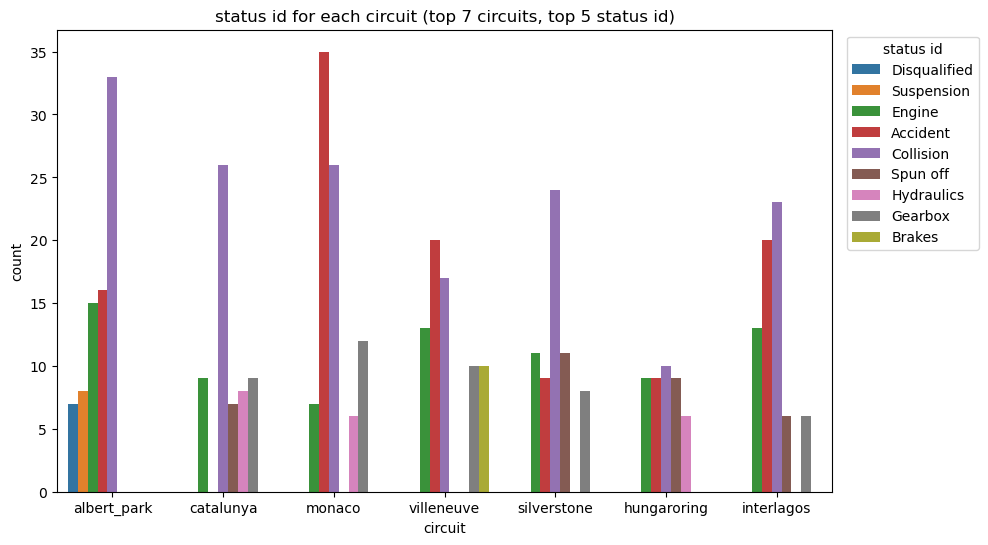

In [18]:
# import circuit data
circuits = pd.read_csv('./data/circuits.csv')

# drop irrelevant columns 
results_null_pos_new = results_null_pos.drop(['time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'], axis=1)
results_null_pos_new

# merge circuit id and name to the dataframe.
results_null_pos_new = results_null_pos_new.merge(races[['raceId', 'circuitId']], on='raceId', how='left')
# group by circuit and remove status id = 1
circuit_dnf = results_null_pos_new.groupby('circuitId')['statusId'].value_counts().reset_index(name='count').sort_values(by=['circuitId', 'statusId'])
circuit_dnf = circuit_dnf.loc[circuit_dnf['statusId'] != 1]

# extract top 5 circuits with the most dnfs
circuit_top_5_dnf = circuit_dnf.groupby('circuitId')['count'].sum().reset_index().nlargest(7, 'count')['circuitId'].tolist()
circuit_dnf = circuit_dnf.loc[circuit_dnf['circuitId'].isin(circuit_top_5_dnf)]

# extract top 5 status id for each circuit
# status_count_top = status_count.groupby('year', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))
circuit_dnf_top = circuit_dnf.groupby('circuitId', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))

# merge circuit names and locations / merge status name for each status id
circuit_dnf_top = circuit_dnf_top.merge(circuits[['circuitId', 'circuitRef', 'location', 'country']], on='circuitId', how='left')
# status_count_top = status_count_top.merge(status, on='statusId').sort_values(by=['year', 'count'], ascending=[True, False]).reset_index(drop=True)
circuit_dnf_top = circuit_dnf_top.merge(status, on='statusId').sort_values(by=['circuitId', 'count']).reset_index(drop=True)

# let's plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=circuit_dnf_top, x='circuitRef', y='count', hue='status')
plt.xlabel('circuit')
plt.ylabel('count')
plt.title('status id for each circuit (top 7 circuits, top 5 status id)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title='status id')
plt.show()

Key findings 
- **albert_park (Melbourne, Australia)**: Most of the DNFs were caused by **collisions**. 
- **catalunya (Barcelona, Spain)**: Again, many DNFs were caused by collisions during fight for the position. (**collision**)
- **monaco (monte carlo, monaco)**: One of the trickiest circuits due to its narrow streets and requirement for extreme precision. Here, there are a lot of **accidents**, which means the driver had an accident by himself (e.g, touching the wall). This shows how challenging monaco GP is, requiring high concentration.
- **silverstone (Silverstone, UK)**: The circuit features several high speed, flowing corners. Locaed in UK, it's notorious for unpredictable and rapidly changing weather. This may have contributed to a lot of **accidents**. 
- **hungaroring (Budapest, Hungary)**: The circuit shows evenly distributed causes of DNF.
- **interlagos (São Paulo, Brazil)**: Interlagos allows for close wheel-to-wheel racing with big elevation changes and extreme weather. **Collisions** and **accidents** are frequent in the circuit.

** *collision* occurs between the drivers, while *accident* happens by the driver himself.
  

## Statistical Methods

### 1. Are there any statistical difference in the average points scored per race by a constructor in two different dominant eras? 

In the new V6 hybrid era, there have been two dominant constructors. **Mercedes-AMG (2014~2020) and Red Bull Racing (2021~2024)**.   
(Mclaren won 2024 constructor championship, but Max Verstappen from Red Bull was way above the other drivers in the championship)   

**Two sample T-test** can be used 
- to compare the means of two independent samples.
- when population standard deviation is unknown.
- estimating the difference in means.


1. Hypothesis:
   - **Null Hypothesis**: The mean points per race for Mercedes era and Redbull era are the same.
   - **Alternative Hypothesis**: The mean points are not the same. (two tailed test)

2. **Significance Level**: 5% (or 0.05)
    - probability of rejecting null hypothesis which is True.

3. Find **p-value**

4. Reject or fail to reject null hypothesis.

In [19]:
# prepare ids for each constructor
merc_id = constructors.loc[constructors['constructorRef'] == 'mercedes', 'constructorId'].iloc[0]
rb_id = constructors.loc[constructors['constructorRef'] == 'red_bull', 'constructorId'].iloc[0]

print(f'mercedes-amg id: {merc_id}')
print(f'red_bull id: {rb_id}')


mercedes-amg id: 131
red_bull id: 9


In [20]:
# merc and rb points
merc_points = races_const_merged.loc[(races_const_merged['year'].between(2014, 2020)) & (races_const_merged['constructorId'] == merc_id), 'points'].dropna()
rb_points = races_const_merged.loc[(races_const_merged['year'].between(2021, 2024)) & (races_const_merged['constructorId'] == rb_id), 'points'].dropna()

print("== mercedes data == ")
print(f"number of races: {len(merc_points)}")
print(f"average points per race: {merc_points.mean()}")

print('-'*50)

print("== red_bull data == ")
print(f"number of races: {len(rb_points)}")
print(f"average points per race: {rb_points.mean()}")


== mercedes data == 
number of races: 138
average points per race: 34.81159420289855
--------------------------------------------------
== red_bull data == 
number of races: 90
average points per race: 31.038888888888888


One of the assumptions for T-test is that the data should be normally distributed.

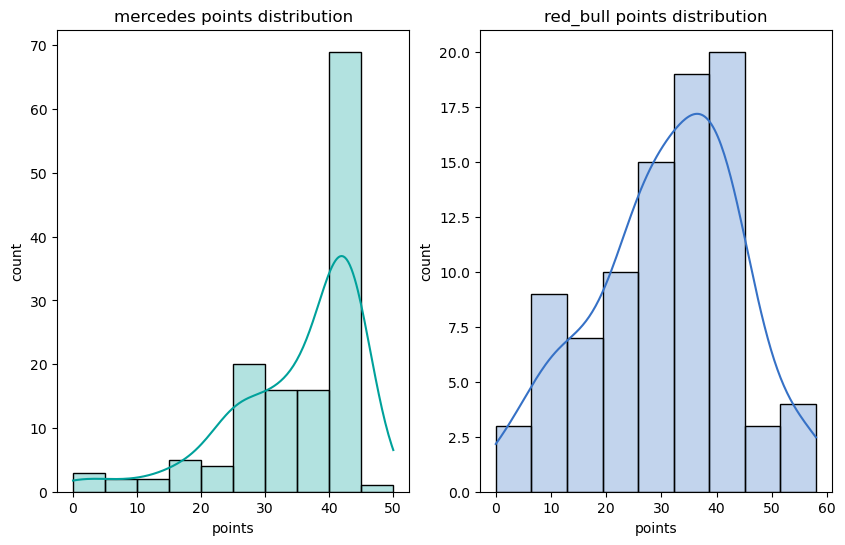

In [21]:
# normality check using histogram
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(merc_points, color='#00A19B', kde=True, alpha=0.3)
plt.title('mercedes points distribution')
plt.xlabel('points')
plt.ylabel('count')

plt.subplot(1, 2, 2)
sns.histplot(rb_points, color='#3671C6', kde=True , alpha=0.3)
plt.title('red_bull points distribution')
plt.xlabel('points')
plt.ylabel('count')

plt.show()


The graphs are left skewed.    
However, T-test is robust to violations of the normality assumption, thanks to the Central Limit Theorem (CLT).   
Therefore, I continue with T-test

In [22]:
# equal variance is set to False because I could not assume the populations had equal variance.
# two-sided to check if means are equal or not
t_score, p_val = stats.ttest_ind(merc_points, rb_points, equal_var=False, alternative='two-sided')

print('== T-test result == ')
print(f"T-score: {t_score:.4f}")
print(f"p-value: {p_val:.4f}")

== T-test result == 
T-score: 2.3078
p-value: 0.0223


We got **p-value** of 0.0223, which is smaller than 0.05, the significance level.   
Therefore, reject the null hypothesis: The means are not equal.   
There are statistically significant difference in the average point per race between the Merc era and the RB era.  

**T-score** of 2.3078.  

- Conclusion: This means that the first sample, `merc_points`, has a bigger mean of points per race than `rb_points`, the second sample.



### Confidence Interval for Pole Position Finish
- Goal: What is the 95% confidence interval for the average result position for drivers who started on pole positon (p1)?

Use **confidence interval** for a range of possible values for the true population mean. Inferential statistics are often more useful than definitive statistics, as it gives a range and shows confidence level.   

1. Identify sample statistic : mean
2. Choose confidence level: 
   - 95%, as it is the most frequently used value.
3. Find Margin of Error (z-score and standard error is needed)
   - For the confidence level of 95%, the z-score is known to be 1.960
   - Given standard error, the function `scipy.stats.norm.interval()` will take care of calculating Margin of Error.
4. Calculate the interval.

In [23]:
# reminder for the structure of the dataset.
qual_res_merged.head(5)

,qualifyId,raceId,driverId,constructorId,number_qualifying,position_qualifying,resultId,number_race,grid,position_race,...,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,position_gain
0,1,18,1,1,22,1,1.0,22.0,1.0,1.0,...,10.0,58.0,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1.0,0.0
1,2,18,9,2,4,2,9.0,4.0,2.0,NaN,...,0.0,47.0,NaN,NaN,15.0,9.0,1:28.753,215.100,4.0,NaN
2,3,18,5,1,23,3,5.0,23.0,3.0,5.0,...,4.0,58.0,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1.0,-2.0
3,4,18,13,6,2,4,13.0,2.0,4.0,NaN,...,0.0,29.0,NaN,NaN,23.0,6.0,1:28.175,216.510,5.0,NaN
4,5,18,2,2,3,5,2.0,3.0,5.0,2.0,...,8.0,58.0,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1.0,3.0


In [24]:
# only keep drivers who qualified on pole position. qual_pole is a Series.
qual_pole = qual_res_merged.loc[qual_res_merged['position_qualifying']==1, 'position_race']

# replace NaN: There have been 20 drivers on the grid since 2001. Thus, I replace NaN values with 21.
qual_pole = qual_pole.fillna(21)

# import relevant library and module
from scipy.stats import norm

# confidence: confidence level
# loc: sample mean
# scale: sample standard error

# sample mean 
mean = qual_pole.mean()

# standard error
se = qual_pole.std() / np.sqrt(len(qual_pole))

norm.interval(confidence=0.95, loc=mean, scale=se)

(3.3631572004365733, 4.479070177753682)

- Conclusion
  - The result is **(3.36, 4.48)** with **95%** confidence level.   
  - This means that the average final position for pole sitters in qualifying usually end up **between 3rd and 5th place**.   


- Keeping the first position in Formula One is extremely challenging because
  - Cars behind have advantages of: DRS and slipstreams
  - Different race strategies, pit-stops, and car setups. 
  - Unexpected events like safety car, collision, and weather
  - Mental fatigue and small mistakes
  
